In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
scaler = StandardScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)


train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -2000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)

train = train.drop([93828,47032,133359,120394,120721,120339,35853],axis=0).reset_index(drop=True)

In [2]:
train_x = train.drop('type_num', axis=1)
train_y = train['type_num']
test_x = test
sc_col = train_x.iloc[:,:21].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [16]:
train_x_sc = scaler.fit_transform(train_x)
test_x_sc = scaler.transform(test_x)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.25, random_state=42)

for train_index, test_index in split.split(train_x_sc, train_y):
    x_train, y_train = train_x_sc[train_index], train_y[train_index]
    x_val, y_val = train_x_sc[test_index] , train_y[test_index]

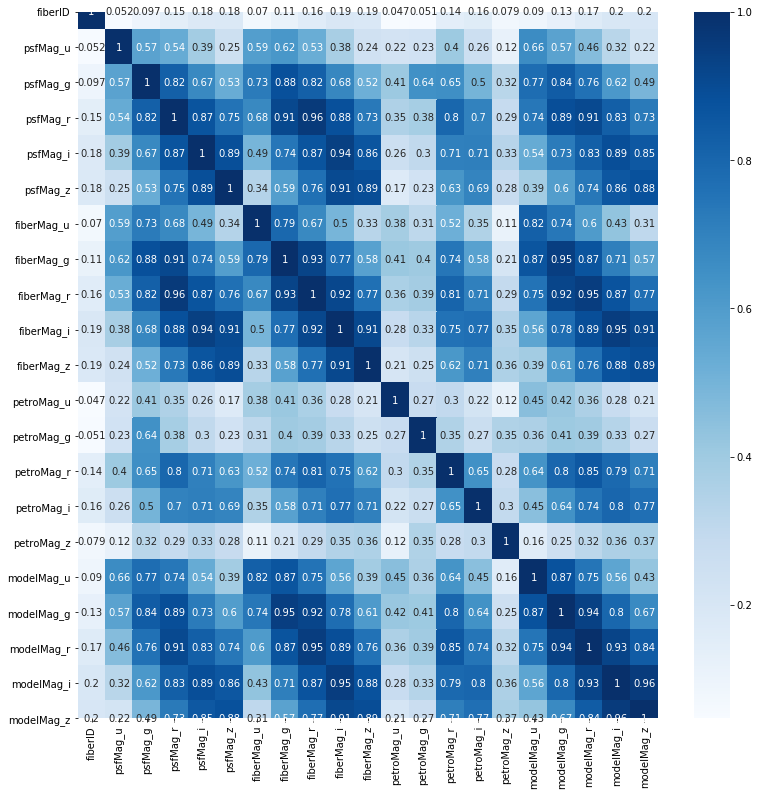

In [10]:
corrmat = pd.DataFrame(train_x_sc,columns= sc_col).corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="Blues")

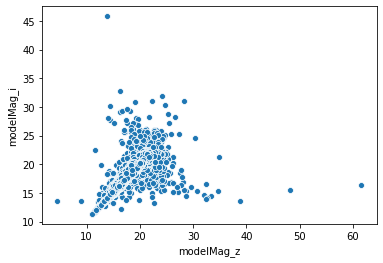

In [31]:
sns.scatterplot(train_x.iloc[:,20],train_x.iloc[:,19])

In [4]:
y_train.value_counts()

8     43716
6     32853
18    19145
15    12873
4     12862
10    12099
5     11875
13     6276
11     5786
1      5725
7      4095
14     2866
3      2254
0      1901
16     1015
2       440
9       112
17       54
12       11
Name: type_num, dtype: int64

In [17]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=123, smote=SMOTE(sampling_strategy='auto', ratio={2:450,17:100,12:80}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {8:36800,6:27800,18:15800})).fit_sample(x_train, y_train)

In [18]:
pd.Series(y_samp).value_counts()

8     35367
6     27572
18    14491
15    10972
4     10962
10    10312
5     10120
13     5349
11     4931
1      4879
7      3490
14     2443
3      1921
0      1620
16      865
2       450
17      100
9        95
12       80
dtype: int64

In [21]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=250, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 5,
                             n_estimators=10000, subsample_for_bin=250000, objective='multiclass', min_split_gain=0.34, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.005, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's multi_logloss: 0.904358
[400]	valid_0's multi_logloss: 0.578265
[600]	valid_0's multi_logloss: 0.459132


KeyboardInterrupt: 

In [ ]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 5,
                             n_estimators=10000, subsample_for_bin=250000, objective='multiclass', min_split_gain=0.34, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.005, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

In [20]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=250, max_depth=-1, learning_rate=0.003, min_data_in_leaf = 4,
                             n_estimators=10000, subsample_for_bin=250000, objective='multiclass', min_split_gain=0.34, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.005, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(X_samp, y_samp, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's multi_logloss: 1.18345
[400]	valid_0's multi_logloss: 0.806389
[600]	valid_0's multi_logloss: 0.617623
[800]	valid_0's multi_logloss: 0.515662
[1000]	valid_0's multi_logloss: 0.45844
[1200]	valid_0's multi_logloss: 0.425033
[1400]	valid_0's multi_logloss: 0.40534
[1600]	valid_0's multi_logloss: 0.393426
[1800]	valid_0's multi_logloss: 0.386366
[2000]	valid_0's multi_logloss: 0.381819
[2200]	valid_0's multi_logloss: 0.379059
[2400]	valid_0's multi_logloss: 0.377263
[2600]	valid_0's multi_logloss: 0.376142
[2800]	valid_0's multi_logloss: 0.375419
[3000]	valid_0's multi_logloss: 0.375012
[3200]	valid_0's multi_logloss: 0.374708
[3400]	valid_0's multi_logloss: 0.374464
[3600]	valid_0's multi_logloss: 0.374347
[3800]	valid_0's multi_logloss: 0.374262
[4000]	valid_0's multi_logloss: 0.374217
[4200]	valid_0's multi_logloss: 0.374193
[4400]	valid_0's multi_logloss: 0.374189
[4600]	valid_0's multi_logloss: 0.374179
[48

(19.0, 0.0)

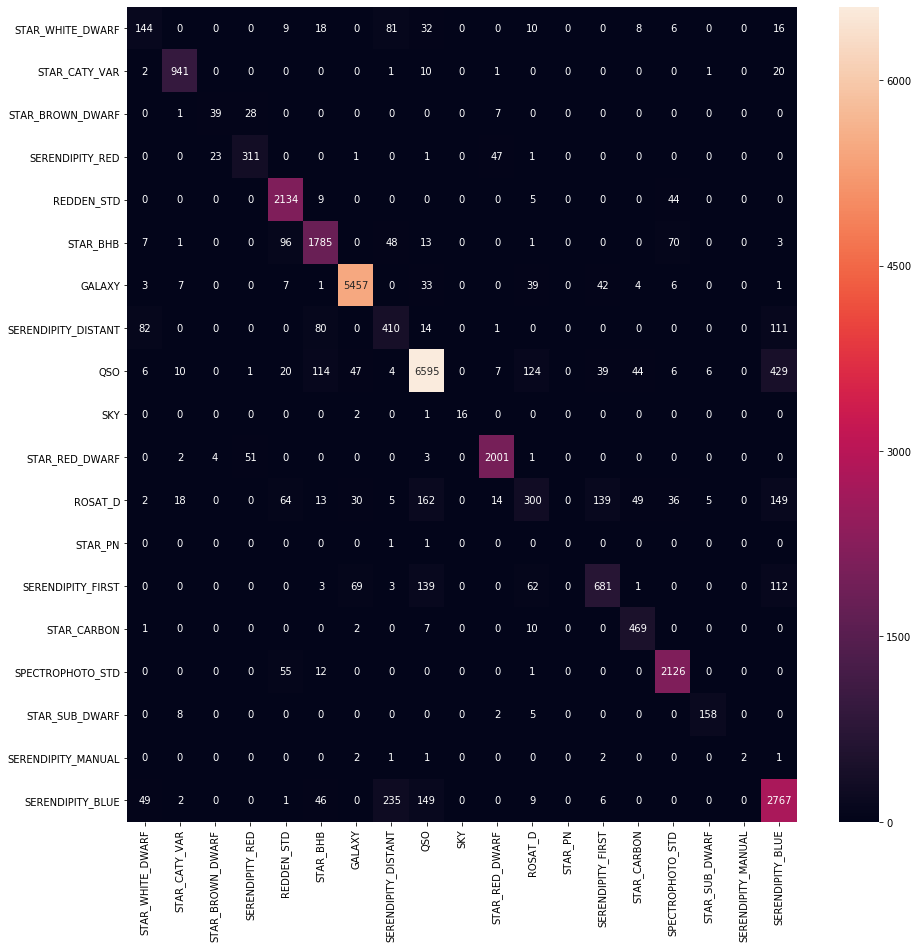

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_val)
plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

(19.0, 0.0)

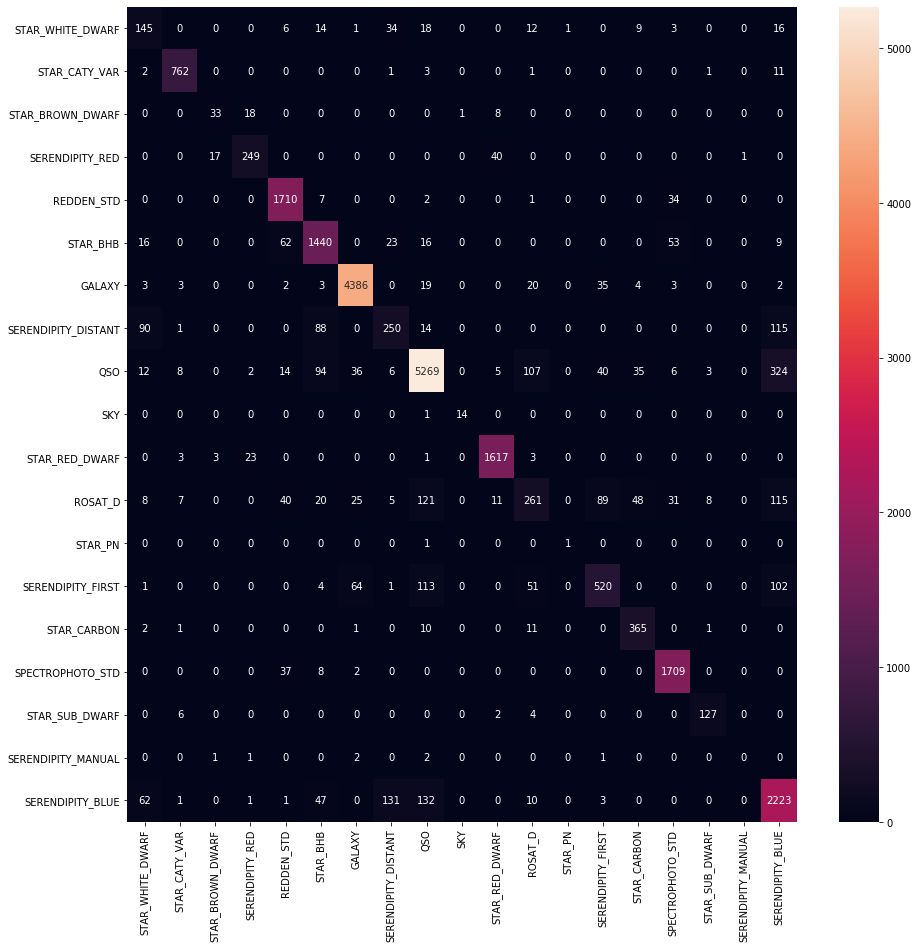

In [8]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_val)
plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.44      0.46       324
           1       0.95      0.96      0.96       976
           2       0.59      0.52      0.55        75
           3       0.80      0.81      0.80       384
           4       0.89      0.97      0.93      2192
           5       0.86      0.88      0.87      2024
           6       0.97      0.97      0.97      5600
           7       0.52      0.59      0.55       698
           8       0.92      0.88      0.90      7452
           9       1.00      0.84      0.91        19
          10       0.96      0.97      0.97      2062
          11       0.53      0.30      0.39       986
          12       0.00      0.00      0.00         2
          13       0.75      0.64      0.69      1070
          14       0.82      0.96      0.88       489
          15       0.93      0.97      0.95      2194
          16       0.93      0.91      0.92       173
          17       1.00    

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.43      0.56      0.48       259
           1       0.96      0.98      0.97       781
           2       0.61      0.55      0.58        60
           3       0.85      0.81      0.83       307
           4       0.91      0.97      0.94      1754
           5       0.83      0.89      0.86      1619
           6       0.97      0.98      0.97      4480
           7       0.55      0.45      0.50       558
           8       0.92      0.88      0.90      5961
           9       0.93      0.93      0.93        15
          10       0.96      0.98      0.97      1650
          11       0.54      0.33      0.41       789
          12       0.50      0.50      0.50         2
          13       0.76      0.61      0.67       856
          14       0.79      0.93      0.86       391
          15       0.93      0.97      0.95      1756
          16       0.91      0.91      0.91       139
          17       0.00    